## APS360 Data processing for music genre categorization

## Packages and some examples

In [ ]:
import os
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import requests
import scipy.signal as signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import GTzan dataset, which I use the existing code
# from https://deeplearning.neuromatch.io/projects/ComputerVision/spectrogram_analysis.html
# done
fname = "music.zip"
url = "https://osf.io/drjhb/download"
# Downloading the zip file from the mirror website
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
  # Unzip the data
  from zipfile import ZipFile

  with ZipFile(fname, 'r') as zipObj:
  # Extract the data to the Data" subfolder
    zipObj.extractall()

In [ ]:
# Listen to one sample file in the downloaded dataset

sample_path = 'drive/MyDrive/Data/genres_original/blues/blues.00099.wav'
display.Audio(sample_path)

# if take a look at the colab "files" sidebar, we can see that GTzan dataset
# 10 different musical genres with 100 30s recordings for each genre

Audio Signal (y):                        [-0.00332642 -0.01135254 -0.00799561 ...  0.00863647  0.01904297
  0.02990723]
Audio Signal Shape:                      (661794,)
Sample Rate (KHz):                       22050
Length of Audio (seconds):               30.013333333333332


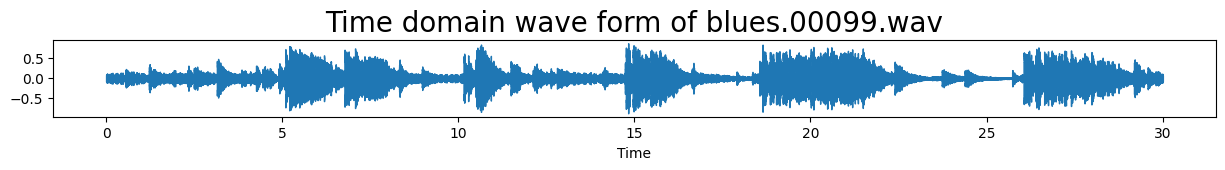

In [ ]:
# the time domain figure of the sample file in the downloaded dataset
y, sample_rate = librosa.load(sample_path)

table = [
    ["Audio Signal (y):", y],
    ["Audio Signal Shape:", np.shape(y)],
    ["Sample Rate (KHz):", sample_rate],
    ["Length of Audio (seconds):", np.shape(y)[0] / sample_rate]
]

# Display the table
for row in table:
    print(f'{row[0]:<40} {row[1]}')
# Plot th sound wave.

plt.figure(figsize=(15, 1))
librosa.display.waveshow(y=y, sr=sample_rate);
plt.title("Time domain wave form of blues.00099.wav", fontsize=20)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


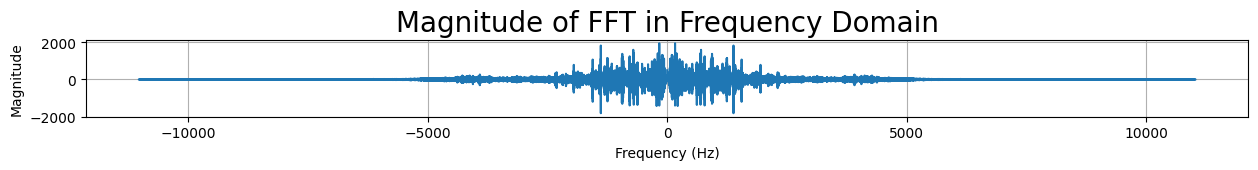

In [ ]:
# The FFT decomposes a signal into its constituent sinusoidal components
# at different frequencies, allowing you to determine the relative strength
# and phase of each component.

# Calculate the Fast Fourier Transform (FFT)
fft_result = np.fft.fft(y)
magnitude = fft_result
frequencies = np.fft.fftfreq(len(magnitude), 1 / sample_rate)

# Plot the magnitude of the FFT result in the frequency domain
plt.figure(figsize=(15, 1))
plt.plot(frequencies, magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude of FFT in Frequency Domain", fontsize=20)
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

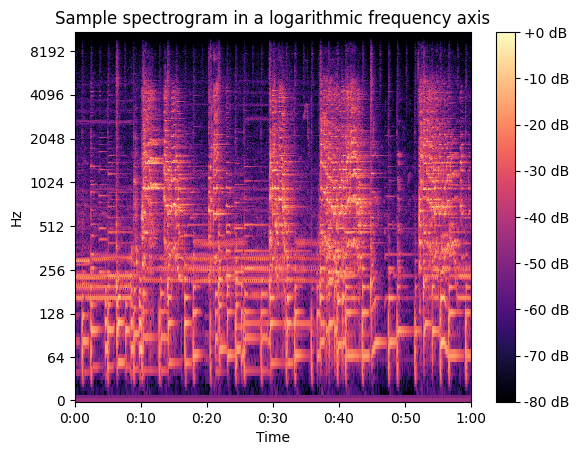

In [ ]:
# A spectrogram is a visual representation of the spectrum of frequencies
# of a signal as it varies with time.

D = librosa.stft(y,hop_length=256, n_fft=4096)# STFT of y, hop_length is related
# to the time resolution, and n_fft relates to the frequency resolution
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Sample spectrogram in a logarithmic frequency axis')
fig.colorbar(img, ax=ax, format="%+2.f dB")

<Figure size 640x480 with 0 Axes>

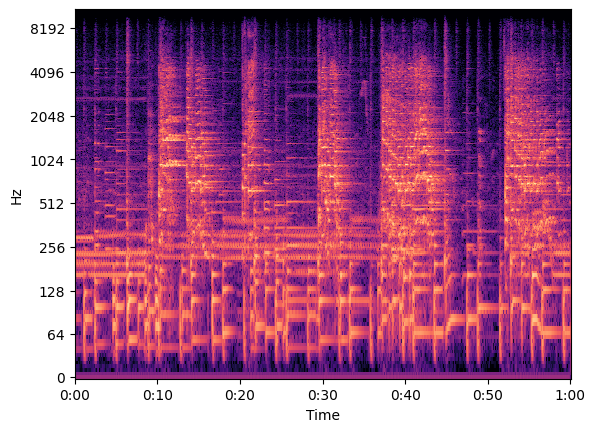

In [ ]:
# A spectrogram is a visual representation of the spectrum of frequencies
# of a signal as it varies with time.

D = librosa.stft(y,hop_length=256, n_fft=4096)# STFT of y, hop_length is related
# to the time resolution, and n_fft relates to the frequency resolution
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log')

## Data processing and storage

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Define paths
dataset_path = "drive/MyDrive/Data/Data/genres_original/"
#output_directory = f"{dataset_path}/spectrograms"
output_directory=dataset_path
filtered_audio_storage="Data/filtered_audio"
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)
os.makedirs(filtered_audio_storage, exist_ok=True)

# Process all audio files in the dataset
genres = os.listdir(dataset_path)
#for genre in reversed(genres):
genre="blues"
dataset_path_sub=f"{dataset_path}/{genre}"
output_directory=dataset_path_sub
# Define a function to process an audio file and save the spectrogram
def process_audio_file(file_path):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path)

    # Apply filters

    # Frequency range: human ear
    lowcut = 20  # Lower cutoff frequency in Hz
    highcut = 20000  # Upper cutoff frequency in Hz

    # Design a band-pass filter using the butterworth filter design
    order = 5  # Filter order
    lowcut /=1* sample_rate
    highcut /=1* sample_rate

    # Design a band-pass filter using the butterworth filter design
    order = 2  # Filter order
    b, a = signal.butter(order, [lowcut, highcut], btype='band')

    # Apply the filter to your audio data
    filtered_audio = signal.lfilter(b, a, audio_data)

    D = librosa.stft(filtered_audio,hop_length=256, n_fft=4096)
    # STFT of y, hop_length is related
    # to the time resolution, and n_fft relates to the frequency resolution
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Extract the file name (without extension) for saving
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Define the output file path for the spectrogram image
    output_file = os.path.join(output_directory, f"{file_name}.png")
    # save memory
    plt.clf()
    clear_output(wait=True)
    plt.close()
    # Plot and save the spectrogram
    plt.figure(figsize=(15, 5))
    plt.figure()
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_db, x_axis='off', y_axis='off', ax=ax)
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    print("Spectrograms saved in:", output_file)
    # save memory
    plt.clf()
    clear_output(wait=True)
    plt.close()
for root, dirs, files in os.walk(dataset_path_sub):
    for file in files:
        if file.endswith(".wav"):
          # Use os.path.basename to get the filename
          filename = os.path.basename(file)

          # Split the filename by the dot to separate the name and extension
          filename_without_extension = os.path.splitext(filename)[0]
          #print(f"{filename_without_extension}")
          #if not os.path.isfile(f"{dataset_path_sub}{filename_without_extension}.png"):
            #print(f"no {filename_without_extension}.png before")
          try:
            audio_file_path = os.path.join(root, file)
            process_audio_file(audio_file_path)
            # save memory
            plt.clf()
            clear_output(wait=True)
            plt.close()
          except Exception as e:
            print(f"Caught an exception: {e}")
          finally:
            ''

## Employing a simple CNN related to spectrogram


In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

device = set_device()


In [ ]:
import os
import shutil
import glob
import random

# Define directories
spectrograms_dir ="drive/MyDrive/Data/genres_original/"
folder_names = ['drive/MyDrive/Data/train/', 'drive/MyDrive/Data/test/', 'drive/MyDrive/Data/val/']
train_dir, test_dir, val_dir = folder_names

# Create or clear directories
for folder in folder_names:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Loop over genres
genres = os.listdir(spectrograms_dir)
for genre in genres:
    # Find all images
    src_file_paths = glob.glob(os.path.join(spectrograms_dir, genre, "*.png"))
    random.shuffle(src_file_paths)

    # Split data into train, test, and validation sets
    test_files = src_file_paths[:10]
    val_files = src_file_paths[10:20]
    train_files = src_file_paths[20:]

    # Create destination folders for train and test images
    for folder in folder_names:
        genre_dir = os.path.join(folder, genre)
        os.makedirs(genre_dir, exist_ok=True)

    # Copy images to the respective directories
    for f in train_files:
        dest_path = os.path.join(train_dir, genre, os.path.basename(f))
        shutil.copy(f, dest_path)
    for f in test_files:
        dest_path = os.path.join(test_dir, genre, os.path.basename(f))
        shutil.copy(f, dest_path)
    for f in val_files:
        dest_path = os.path.join(val_dir, genre, os.path.basename(f))
        shutil.copy(f, dest_path)


In [ ]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=25, shuffle=True, num_workers=0)


In [ ]:
class music_net(nn.Module):
    def __init__(self):
        super(music_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 62 * 46, 128)  # Adjust the input size based on your input image shape
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = x.view(-1, 64 * 62 * 46)  # Adjust the size based on your input image shape
        x = self.fc1(x)
        x = self.fc2(x)
        return x




def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

In [ ]:



# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

  0%|          | 0/50 [00:00<?, ?epoch/s]

FileNotFoundError: ignored